In [1]:
import tensorflow as tf
import visual_data_explanation as vde
from gridworld import GridworldMdp
from utils import plot_trajectory, plot_reward, plot_reward_and_trajectories
from fast_agents import FastOptimalAgent
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

/Users/ngundotra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
saver = tf.train.import_meta_graph("model_save_sess_0/.meta")
graph = tf.get_default_graph()
sess = tf.Session(graph = graph)
# necessary to reload the ** tf.VARIABLES ** that allow training to occur
saver.restore(sess, "model_save_sess/")

INFO:tensorflow:Restoring parameters from model_save_sess/


In [3]:
# This should be a list of <tf.Variable '...', >
graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'reward:0' shape=(20, 8, 8) dtype=float32_ref>,
 <tf.Variable 'VIN/bias:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w1:0' shape=(1, 1, 150, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w:0' shape=(3, 3, 5, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_fb:0' shape=(3, 3, 1, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_o:0' shape=(5, 5) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'VIN/bias/Adam:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/bias/Adam_1:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0/Adam:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0/Adam_1:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w1/Adam:0' shape=(1, 1, 150, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w1/Adam_1:0' shape=(1, 1, 150, 5) dtype=float32_re

In [4]:
tfvars = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
reward_var = None
for v in tfvars:
    if 'reward:0' in v.name:
        print(v)
        reward_var = v

<tf.Variable 'reward:0' shape=(20, 8, 8) dtype=float32_ref>


In [5]:
# Need 3 things: reward_optimize_op, err, step2_cost
labels = graph.get_tensor_by_name('y:0')
w_o = graph.get_tensor_by_name("VIN/w_o:0")
q = graph.get_tensor_by_name("q_20:0")
q_out = tf.reshape(q, [-1, 5])
logits = tf.matmul(q_out, w_o)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=labels, name='cross_entropy-z')
cross_entropy_mean = tf.reduce_mean(
    cross_entropy, name='cross_entropy_mean-z')
logits_cost = tf.add_n([cross_entropy_mean], name='logits_loss')

reward_regularizer_C = 0.1
l1_regularizer = tf.contrib.layers.l1_regularizer(reward_regularizer_C)
reward_regularizer_cost = tf.contrib.layers.apply_regularization(l1_regularizer, [reward_var])
step2_cost = logits_cost 

reward_lr = 1.5 # default in config file
reward_optimizer = tf.train.AdamOptimizer(reward_lr, name='adam-opt')
reward_optimize_op = reward_optimizer.minimize(step2_cost, var_list=[reward_var], name='reward_optim')
# reward_optimize_op = graph.get_operation_by_name('reward/Adam')

num_actions = 5
labels = tf.reshape(graph.get_tensor_by_name('y:0'), [-1, num_actions])
cp = tf.cast(tf.argmax(graph.get_tensor_by_name("output:0"), 1), tf.int32)
most_likely_labels = tf.cast(tf.argmax(labels, axis=1), tf.int32)
err = tf.reduce_mean(tf.cast(tf.not_equal(cp, most_likely_labels), dtype=tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [6]:
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
graph.get_collection("losses")

[<tf.Tensor 'cross_entropy_mean:0' shape=() dtype=float32>]

In [8]:
vtensors = set()
for op in graph.get_operations():
    if 'v_' in op.name and 'grad' not in op.name and '/' not in op.name:
        vtensors.add(op)

# Find all the value maps, later we'll sort them & plot them
sortable_vtensors = []
greatest = None
greatestnum = 1
for op in vtensors:
    opname = op.name.split('/')[0]
    opnum = int(opname[2:])
    sortable_vtensors.append((opnum, op))
    if opnum > greatestnum:
        greatest = op
        greatestnum = opnum
    
print(greatest)

name: "v_19"
op: "Max"
input: "q_19"
input: "v_19/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}



In [9]:
grids = vde.grids

In [10]:
mdp = GridworldMdp(grids[2])

In [11]:
walls, reward, start = mdp.convert_to_numpy_input()

In [12]:
def repeat_vector(walls, reward, num=20):
    """
    Use to fill out the batch dimension of the VIN model's input.
    Returns the batched (repeated) walls and rewards as tuple"""
    w = np.stack([walls] * 20)
    r = np.stack([reward] * 20)
    return w, r

In [13]:
def normalize(vals):
    vals = vals - vals.mean()
    vals = vals / (vals.max() - vals.min())
    return vals

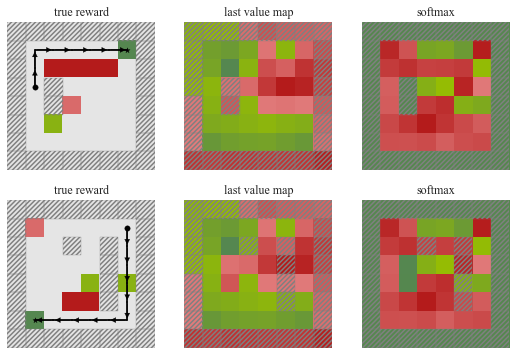

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

w, r = repeat_vector(walls, reward)
for ax, gr in zip(axes, grids[2:4]):
    walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
    
    # plotting softmax output of VIN (last layer)
    oo = graph.get_operation_by_name('output')
    qs = sess.run(feed_dict={'image:0': w, 'reward:0': r}, fetches=oo.outputs)[0]
    values = np.max(qs, axis=-1)
    val = np.reshape(values, (20, 8, 8))[0]
    plot_reward(normalize(val), walls, "softmax", fig, ax[2])
    # plotting actual reward
    agent = FastOptimalAgent(beta=1.0)
    plot_trajectory(walls, reward, start, agent, fig, ax[0])
    plot_reward(reward, walls, "true reward", fig, ax[0])
    # plotting last value map of VIN (last VIN block)
    rvs = greatest
    rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
    rvs = rvs[0][0].squeeze()
    plot_reward(normalize(rvs), walls, 'last value map', fig, ax[1])
    
fig.savefig("testing_value_maps.jpg")

In [15]:
sorted_vtensors = list(sorted(sortable_vtensors))
sorted_vtensors

[(1, <tf.Operation 'v_1' type=Max>),
 (2, <tf.Operation 'v_2' type=Max>),
 (3, <tf.Operation 'v_3' type=Max>),
 (4, <tf.Operation 'v_4' type=Max>),
 (5, <tf.Operation 'v_5' type=Max>),
 (6, <tf.Operation 'v_6' type=Max>),
 (7, <tf.Operation 'v_7' type=Max>),
 (8, <tf.Operation 'v_8' type=Max>),
 (9, <tf.Operation 'v_9' type=Max>),
 (10, <tf.Operation 'v_10' type=Max>),
 (11, <tf.Operation 'v_11' type=Max>),
 (12, <tf.Operation 'v_12' type=Max>),
 (13, <tf.Operation 'v_13' type=Max>),
 (14, <tf.Operation 'v_14' type=Max>),
 (15, <tf.Operation 'v_15' type=Max>),
 (16, <tf.Operation 'v_16' type=Max>),
 (17, <tf.Operation 'v_17' type=Max>),
 (18, <tf.Operation 'v_18' type=Max>),
 (19, <tf.Operation 'v_19' type=Max>)]

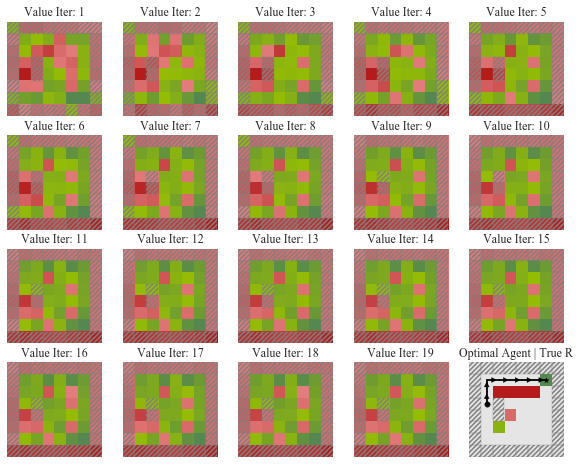

In [16]:
w, r = repeat_vector(walls, reward, num=20)
# Comparing value maps. Rows of 5 value maps. Starting from the first
num_cols = 5
num_rows = round(len(sortable_vtensors) // num_cols + 1)
size_scale = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * size_scale, num_rows * size_scale))


gr = grids[2] # or choose grid 3
walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = 5 * i + j
        if idx >= len(sortable_vtensors):
            # If no more value plots, just plot the trajectory on true reward
            agent = FastOptimalAgent(beta=1.0)
            plot_trajectory(walls, reward, start, agent, fig, ax)
            plot_reward(reward, walls, "Optimal Agent | True R", fig, ax)
        else:
            # Plot value map
            opnum, op = sorted_vtensors[5 * i + j]
            vmap = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=op.outputs)
            vmap = vmap[0][0].squeeze()
            plot_reward(normalize(vmap), walls, 'Value Iter: {}'.format(opnum), fig, ax)
fig.savefig("ValueMapComparison-OptimalAgent-VIN-20.jpg")
            
# Plot rollout of the agent on the actual policy..., compared again with the optimal agent
# Plot rollout on inferred reward as well... 
# fig, axes = plt.subplots(1, 3)


In [17]:
def train_reward(sess, image_data, reward_data, y_data, num_epochs, verbosity, bsize=20):
        """Infers the reward using backprop, holding the planner fixed.

        Due to Tensorflow constraints, image_data must contain exactly
        batch_size number of MDPs on which the reward should be inferred.

        The rewards are initialized to the values in reward_data. If reward_data
        is None, the rewards are initialized to all zeroes.
        """
        from utils import fmt_row
        import time
        if verbosity >= 3:
            print(fmt_row(10, ["Iteration", "Train Cost", "Train Err", "Iter Time"]))
        if reward_data is None:
            reward_data = np.random.randn(*image_data.shape)

        batch_size = bsize
        num_batches = int(image_data.shape[0] / batch_size)
        costs, errs = [], []
        for batch_num in range(num_batches):
            if verbosity >= 2 and batch_num % 10 == 0:
                print('Batch {} of {}'.format(batch_num, num_batches))
            start, end = batch_num * batch_size, (batch_num + 1) * batch_size
            # We can't feed in reward_data directly to self.reward, because then
            # it will treat it as a constant and will not be able to update it
            # with backprop. Instead, we first run an op that assigns the
            # reward, and only then do the backprop.
            fd = {
                "reward_input:0": reward_data[start:end],
            }
            assign_reward = reward_var.assign(graph.get_tensor_by_name("reward_input:0"))
            sess.run([assign_reward], feed_dict=fd)
            print(np.sum(np.ravel(sess.run([]))))

            if batch_num % 10 == 0:
                costs.append([])
                errs.append([])
            for epoch in range(num_epochs):
                tstart = time.time()
                fd = {
                    "image:0": image_data[start:end],
                    "y:0": y_data[start:end]
                }
                _, e_, c_ = sess.run(
                    [reward_optimize_op, err, step2_cost],
                    feed_dict=fd)
                elapsed = time.time() - tstart
                if verbosity >= 3 and batch_num % 10 == 0:
                    print(fmt_row(10, [epoch, c_, e_, elapsed]))
                    costs[-1].append(c_)
                    errs[-1].append(e_)

            reward_data[start:end] = reward_var.eval(sess)

#         logs['train_reward_costs'].append(costs)
#         logs['train_reward_errs'].append(errs)
        return reward_data

In [18]:
# generate_data_for_reward( agent, num_w/oreward)
# y_irl = ydata = 4th return of generate data AKA labels
imsize = 8
num_actions = 5
def generate_data_for_reward(mdp, agent):
    from utils import Distribution
    from gridworld import Direction
    def dist_to_numpy(dist):
        return dist.as_numpy_array(Direction.get_number_from_direction, num_actions)

    def action(state):
        # Walls are invalid states and the MDP will refuse to give an action for
        # them. However, the VIN's architecture requires it to provide an action
        # distribution for walls too, so hardcode it to always be STAY.
        x, y = state
        if mdp.walls[y][x]:
            return dist_to_numpy(Distribution({Direction.STAY : 1}))
        return dist_to_numpy(agent.get_action_distribution(state))
    
    agent.set_mdp(mdp)
    action_dists = [[action((x, y)) for x in range(imsize)] for y in range(imsize)]
    action_dists = np.array(action_dists)

    walls, rewards, start_state = mdp.convert_to_numpy_input()
    return action_dists


In [19]:
sess.run(tf.global_variables_initializer())

 Iteration | Train Cost |  Train Err |  Iter Time
Batch 0 of 1
0.0
         0 |  1.6094364 |  0.8148438 |   0.263173
         1 |  1.6094364 |   0.815625 |  0.0153332
         2 |  1.6094364 |   0.815625 |  0.0152812
         3 |  1.6094364 |     0.8125 |  0.0146568
         4 |  1.6094364 | 0.81171876 |  0.0141242
         5 |  1.6094364 |     0.8125 |    0.01406
         6 |  1.6094364 |  0.8140625 |   0.014185
         7 |  1.6094364 |  0.8101562 |  0.0151792
         8 |  1.6094364 |  0.8101562 |  0.0146441
         9 |  1.6094364 | 0.80859375 |  0.0145781
        10 |  1.6094364 |  0.8078125 |  0.0144081
        11 |  1.6094364 |  0.8046875 |   0.014271
        12 |  1.6094364 | 0.80078125 |  0.0143633
        13 |  1.6094364 |  0.7984375 |  0.0141659
        14 |  1.6094364 |  0.7992188 |  0.0149088
        15 |  1.6094364 |  0.7953125 |  0.0155728
        16 |  1.6094364 |    0.79375 |   0.018086
        17 |  1.6094364 | 0.79296875 |  0.0166612
        18 |  1.6094364 |   0.790

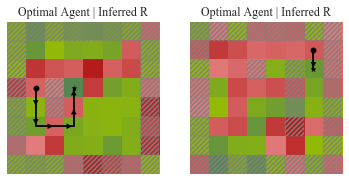

In [20]:
def visualize_inferred_on_grid(grid, train_agent, optimal_agent, ax, norm=False, ax_title=None,
                              num_epochs=40, verbosity=3):
    """
    Infers the reward for a given grid mdp, the agent the model was trained on, and then plots the trajectory of
    the optimal agent on the inferred reward. If normalize is true, we normalize the reward before plotting 
    trajectory & visualizing.
    
    Uses `train_agent` to infer the reward, and `optimal_agent` to visualize best path planning with the inferred reward.
    """
    mdp = GridworldMdp(grid)
    walls, reward, start = mdp.convert_to_numpy_input()
    
    agent = FastOptimalAgent(beta=1.0)
    y_data = generate_data_for_reward(mdp, train_agent)

    repeat_walls, repeat_ys = repeat_vector(walls, y_data)
    reward_data = train_reward(sess, repeat_walls, None, repeat_ys, num_epochs, verbosity, bsize=20)
    if norm:
        reward_data[0] = normalize(reward_data[0])
        
    if ax_title is None:
        ax_title = "Optimal Agent | Inferred R"
    agent = FastOptimalAgent(beta=None)
    plot_trajectory(walls, reward_data[0], start, optimal_agent, fig, ax)
    plot_reward(reward_data[0], walls, ax_title, fig, ax)

fig, axes = plt.subplots(1, 2)
opt_agent = FastOptimalAgent(beta=None)
train_agent = FastOptimalAgent(beta=1.0)

visualize_inferred_on_grid(grids[2], train_agent, opt_agent, axes[0], num_epochs=50)
visualize_inferred_on_grid(grids[3], train_agent, opt_agent, axes[1], num_epochs=50)

# Tying the Visualizations Together

In [20]:
def plot_vis_grid(grid, train_agent, optimal_agent=None, fname="ValueMapComparison.jpg",
                 num_cols=5, size_scale=2):
    """
    Visualizes model's performance on a given grid. Utilizes a saved model constructed in train.py 
    passed with --savedmodel True.
    
    Visualizes value maps, then optimal performance on the true reward, optiaml performance on inferred rewards,
    demonstrator's performance on the inferred rewards, and optimal performance on values from the model's output
    """
    if optimal_agent is None:
        optimal_agent = FastOptimalAgent(beta=1.0)
    NUM_LAST = 3
    if num_cols < NUM_LAST:
        raise ValueError("Need at least 3 columns to visualize inferred reward's relationship to true reward")
    # Calculate the number of rows to see every value iteration in the VIN
    num_rows = round(len(sortable_vtensors) // num_cols + 1)
    # Add an extra row to see the inferred reward & stuff
    fig, axes = plt.subplots(num_rows + 1, num_cols, figsize=(num_cols * size_scale, num_rows * size_scale))

    mdp = GridworldMdp(grid)
    walls, reward, start = mdp.convert_to_numpy_input()
    w, r = repeat_vector(walls, reward,num=20)
    for i, ax_row in enumerate(axes[:-1]):
        for j, ax in enumerate(ax_row):
            idx = 5 * i + j
            if idx < len(sorted_vtensors):
                # Plot value map
                opnum, op = sorted_vtensors[5 * i + j]
                vmap = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=op.outputs)
                vmap = vmap[0][0].squeeze()
                plot_reward(normalize(vmap), walls, 'Value Iter: {}'.format(opnum), fig, ax)
            else:
                ax.set_visible(False)
    
    last_row = axes[-1, :]
    # Demonstrator Agent | True Reward
    plot_trajectory(walls, reward, start, train_agent, fig, last_row[0])
    plot_reward(reward, walls, "Demonstrator | True", fig, last_row[0])
    # Optimal Agent | Inferred Reward
    visualize_inferred_on_grid(grid, train_agent, optimal_agent, last_row[1], ax_title="Optimal | Inferred")
    # Train Agent | Inferred Reward
#     visualize_inferred_on_grid(grid, train_agent, train_agent, last_row[2], ax_title='Demonstrator | Inferred')
    # Demonstrator | Model's Values
    vals = plot_models_best_trajectory(mdp, train_agent, fig, last_row[2])
    plot_reward(vals, walls, "Demonstrator | Model", fig, last_row[2])
    for ax in last_row[NUM_LAST:]:
        ax.set_visible(False)
    fig.savefig(fname, dpi=150)

def plot_models_best_trajectory(mdp, demonstrator, fig, ax, bsize=20, optimal_base_agent=None):
    """
    Uses optimal agent to plan using the model's values.
    """
    from mdp_interface import Mdp
    from agent_runner import run_agent
    from utils import plot_pos, plot_lines
    EPISODE_LENGTH = 30
    arrow_width = 0.5
    animate=False
    fname=None
    if optimal_base_agent is None:
        optimal_base_agent = FastOptimalAgent(beta=None)
    
    walls, reward, start = mdp.convert_to_numpy_input()
    imsize = len(walls)
    w, r = repeat_vector(walls, reward, num=20)
    vmap = sess.run(feed_dict={'image:0': w, 'reward:0':r}, fetches=graph.get_tensor_by_name('output:0'))
    # Transposing bc internal values for the agent are transposed
    vmap = np.argmax(vmap, -1).reshape((bsize, imsize, imsize))[0].T
    
    # Performing rollout
    demonstrator.set_mdp(mdp)
    # Override the value computation
    demonstrator.values = vmap
    env = Mdp(mdp)
    trajectory = run_agent(demonstrator, env, episode_length=EPISODE_LENGTH)

    if len(trajectory) <= 1:
        raise ValueError("Trajectory rolled out unsuccessfully")

    # Tuples of (state, next) - to be used for plotting
    state_trans = [(info[0], info[2]) for info in trajectory]
    count = 0
    for trans in state_trans:
        if trans[0] == trans[1]:
            count += 1
    if count == len(state_trans):
        print("Yes, the agent given stayed in the same spot for {} iterations...".format(len(state_trans)))

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1)
    if ax is not None and type(ax) is list:
        raise ValueError("Given {} axes, but can only use 1 axis".format(len(ax)))

    # Plot starting point
    plot_pos(start, ax=ax, color='k', marker='o', grid_size=imsize)
    # Plot ending trajectory point
    finish = state_trans[-1][0]
    plot_pos(finish, ax=ax, color='k', marker='*', grid_size=imsize)
    plot_lines(ax, fig, trans_list=state_trans, color='black', arrow_width=arrow_width, grid_size=imsize,
               animate=animate, fname=fname)
    ax.set_xticks([])
    ax.set_yticks([])
    return vmap

In [21]:
graph.get_tensor_by_name('output:0')

<tf.Tensor 'output:0' shape=(1280, 5) dtype=float32>

 Iteration | Train Cost |  Train Err |  Iter Time
Batch 0 of 1
         0 |  1.6094364 |  0.8140625 |   0.016165
         1 |  1.6094364 |  0.8148438 |    0.01507
         2 |  1.6094364 |  0.8171875 |   0.015687
         3 |  1.6094364 |  0.8148438 |  0.0145922
         4 |  1.6094364 |     0.8125 |   0.015413
         5 |  1.6094364 |     0.8125 |   0.014617
         6 |  1.6094364 |  0.8140625 |  0.0152428
         7 |  1.6094364 |     0.8125 |  0.0146189
         8 |  1.6094364 | 0.80859375 |  0.0158949
         9 |  1.6094364 | 0.80390626 |  0.0151951
        10 |  1.6094364 | 0.79765624 |  0.0173869
        11 |  1.6094364 |   0.796875 |  0.0203657
        12 |  1.6094364 |  0.7945312 |   0.015976
        13 |  1.6094364 | 0.78828126 |   0.016505
        14 |  1.6094364 |   0.778125 |  0.0148859
        15 |  1.6094364 | 0.77265626 |  0.0143621
        16 |  1.6094364 |    0.76875 |  0.0155377
        17 |  1.6094364 | 0.76640624 |  0.0149031
        18 |  1.6094364 |  0.7601563 

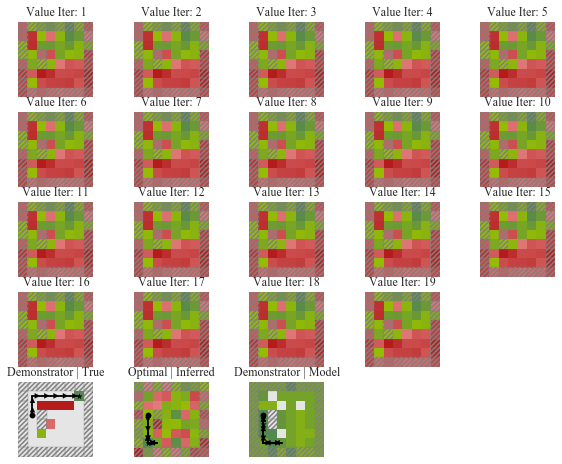

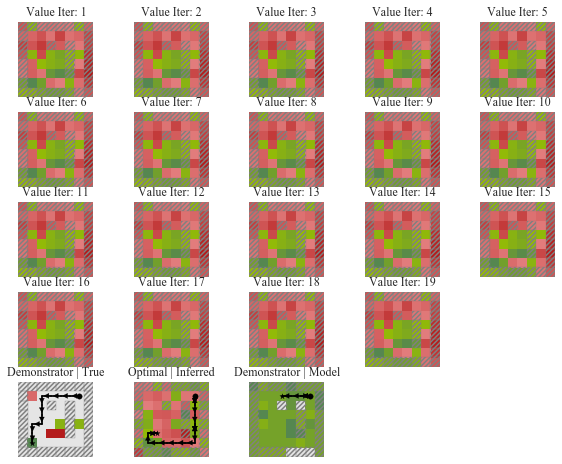

In [22]:
train_agent = FastOptimalAgent(beta=1.0)
plot_vis_grid(grids[2], train_agent, fname='ValueMapComparison-gr1-b.jpg')
plot_vis_grid(grids[3], train_agent, fname='ValueMapComparison-gr2-b.jpg')

## Verifying that the model is properly calculating the error / policy

In [26]:
mdp = GridworldMdp(grids[2])
walls, reward, start = mdp.convert_to_numpy_input()

dists = generate_data_for_reward(mdp, FastOptimalAgent(beta=1.0))

w, r = repeat_vector(np.zeros_like(walls), np.ones_like(reward))
ys = repeat_vector(dists, dists)[0]
fd = {
    "image:0": w,
    "reward_input:0":r,
    "y:0": ys
}
sess.run([err], feed_dict=fd)
# Why is the error so high on this?? Shouldn't it have learned better??
sess.run([])

[0.69609374]

In [56]:
train_opt = tf.train.RMSPropOptimizer(1e-6).minimize(
    logits_cost, name="train-adam", var_list=graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [64]:
boink = graph.get_tensor_by_name("output:0")

In [65]:
police = sess.run([boink], feed_dict=fd)[0]
police

array([[0.20000044, 0.19999975, 0.19999993, 0.20000005, 0.19999975],
       [0.20000046, 0.19999976, 0.19999993, 0.20000023, 0.19999966],
       [0.20000046, 0.19999976, 0.19999993, 0.20000023, 0.19999966],
       ...,
       [0.2000002 , 0.20000006, 0.19999987, 0.19999981, 0.20000009],
       [0.2000002 , 0.20000006, 0.19999987, 0.19999981, 0.2000001 ],
       [0.19999991, 0.20000005, 0.20000003, 0.19999985, 0.2000002 ]],
      dtype=float32)

In [68]:
police[:, 0].var()

2.6503105e-14

In [40]:
graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'VIN/bias:0' shape=(1, 1, 1, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w0:0' shape=(3, 3, 2, 150) dtype=float32_ref>,
 <tf.Variable 'VIN/w1:0' shape=(1, 1, 150, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w:0' shape=(3, 3, 5, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_fb:0' shape=(3, 3, 1, 5) dtype=float32_ref>,
 <tf.Variable 'VIN/w_o:0' shape=(5, 5) dtype=float32_ref>]

In [58]:
sess.run([tf.global_variables_initializer()])

[None]

In [63]:
sess.run([train_opt, err, step2_cost], feed_dict=fd)

[None, 0.640625, 1.6094364]

## Verifying that plotting the model values works as expected

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2c5fd3c8>)

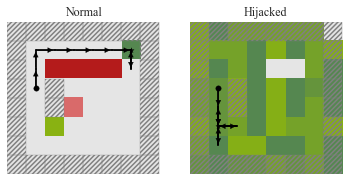

In [30]:
optimal_agent = FastOptimalAgent(beta=1.0)
mdp = GridworldMdp(grids[2])
fig, axes = plt.subplots(1, 2)

walls, reward, start = mdp.convert_to_numpy_input()
plot_trajectory(walls, reward, start, optimal_agent, fig, axes[0])
plot_reward(reward, walls, "Normal", fig, axes[0])

optimal_agent = FastOptimalAgent(beta=1.0)
vmap = plot_models_best_trajectory(mdp, optimal_agent, fig, axes[1])
plot_reward(vmap, walls, "Hijacked", fig, axes[1])